In [1]:
import random
import numpy as np
import Parsing_midi as pm
import Init_chromo as init
import count_CE as ce
import mido
from mido import Message, MidiFile, MidiTrack
from collections import Counter
import copy

from itertools import combinations # product: 排列

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
"""
## import function

- Parsing_midi
    - get_midi
    - get_pitch
    - parse_midi
    - separate_phrase

- Init_chromo
    - shift_note
    - merge_duplicate_note
    - extend_duration
"""
print()

### Seperate phrase
- one bar = 1920 (4 beats)
- sliding window = 7680 (4 bar)
- Parameters:
    - base
    - midi list
    - threshold

In [3]:
midi_list = pm.get_midi('MidiSample/iswear2.mid',0)

## seperate input into 4 bar
def separate_song(song, threshold):
    a = song
    time = 0; t = []; t2 = []; n = []; n2 = []
    for i in range(len(a)):
        time += a[i].time 
        if time <= threshold:
#             time += a[i].time       
            t.append(a[i])
            n.append(a[i].note%12)
            
        else:
            t2.append(t)  # sepatate bar
            n2.append(n)  # index of note
            ## reset
            time = 0 
            t = []
            n = []
            time += a[i].time
            t.append(a[i])
            n.append(a[i].note%12)
    return n2, t2

In [4]:
## transform to C major
for i in range(len(midi_list)):
    midi_list[i].note = midi_list[i].note -2 # shift

In [5]:
## get midi message
pitch_ary = [[0,1,0], [-1,0,7], [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6],\
                 [1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5]]

pitch_ary = np.array(pitch_ary)

def pitch_trans(seq):
    pitch_list = ['C','D','E','F','G','A','B']
    return pitch_list[seq]

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

note_msg, midi_msg = separate_song(midi_list, 1920)

### Evolutionary algorithmn
- selection
- crossover
- mutation
- fitness

In [7]:
## MMAIN -- Initialization
pop_list = [0,1,2,3,4] #目前是5個initial choromosome
candidate = list(combinations(pop_list, 2))

## get midi clip for testing
pops = midi_msg
parent = pops[2]  # change here for testing
parent

[<message note_on channel=0 note=83 velocity=0 time=239>,
 <message note_on channel=0 note=84 velocity=120 time=241>,
 <message note_on channel=0 note=84 velocity=0 time=479>,
 <message note_on channel=0 note=84 velocity=120 time=1>,
 <message note_on channel=0 note=84 velocity=0 time=239>,
 <message note_on channel=0 note=84 velocity=98 time=1>,
 <message note_on channel=0 note=84 velocity=0 time=239>,
 <message note_on channel=0 note=84 velocity=96 time=1>,
 <message note_on channel=0 note=84 velocity=0 time=239>,
 <message note_on channel=0 note=76 velocity=100 time=1>,
 <message note_on channel=0 note=76 velocity=0 time=239>,
 <message note_on channel=0 note=77 velocity=105 time=1>]

In [8]:
MUTATION_RATE = 0.5
CROSSOVER_RATE = 0.8
GENERATIONS = 0
FITNESS_VALUE = 0.5


## Initialize (at least 50)
pop1 = init.shift_note(parent, 3)             # 移調
pop2 = init.shift_note(parent, 5)             # 移調
pop4 = init.merge_duplicate_note(parent)      # 重複的切分音直接轉為連音
pop5 = init.change_duration(parent, 120, 480, 3) # 延長音 16分音符->一拍
pop6 = init.change_duration(parent, 240, 120, 3) # 縮短音 8分音符->16分音符
pop_list = [pop1, pop2, pop4, pop5, pop6]
pops=[]
for i in range(len(pop_list)):
    pops.append(pop_list[i])

    
## Selection
def select(parent=pops):  # select one phrase
    print("selection")
    pop_list = [0,1,2,3,4]
#     idx = np.random.choice(pop_list, replace=True, p=[0.2,0.2,0.2,0.2,0.2])  
    return parent[idx]


## Crossover
"""
Parameter:
crossover_rate
crossover_point
"""
def trans_note_list(song):
    note_list=[]
    for i in range(len(song)):
        note_list.append(song[i].note)
    return note_list

def crossover(parent, pop):
    print("crossover...")
    crossover_rate = round(random.uniform(0, 1),1)
    crossover_point = random.randint(0,len(parent))
    if crossover_rate < CROSSOVER_RATE:
        pop_midi1 = parent[ :crossover_point] + pop[crossover_point: ]
        pop_midi2 = pop[ :crossover_point] + parent[crossover_point: ]
        pop_num1 = trans_note_list(pop_midi1)
        pop_num2 = trans_note_list(pop_midi2)
    # 交換後取分數最高的進行突變
        c1,s1 = fitness(pop_midi1, pop_num1)
        c2,s2 = fitness(pop_midi2, pop_num2)
        if max(c1,c2) == c1:
            return s1 
        else:
            return s2

    else:
        parent_num = trans_note_list(parent)
        pop_num = trans_note_list(pop)
        c1,s1 = fitness(parent, parent_num)
        c2,s2 = fitness(pop, pop_num)
        if max(c1,c2) == c1:
            return s1 
        else:
            return s2
        
    
## Mutation
"""
Parameter:
mute_rate
mute_point
mutate_list
"""
def mutation(child):
    mute_rate = round(random.uniform(0, 1),1)
    if mute_rate < MUTATION_RATE:
        print("mutation...")
        mute_point = random.randint(0,len(child))  #選擇一點做突變
        mutate_note = np.random.choice(12, 1, replace=False, p=[0.2, 0, 0.2, 0, 0.25, 0.05, 0, 0.25, 0, 0.025, 0, 0.025]) #突變之機率
        mutate_list = [child[mute_point].note + int(mutate_note), 0]  #選擇突變或是直接刪除  ##TODO: 相加後可能超過12->跨一八度
        child[mute_point].note = int(np.random.choice(mutate_list, 1, p=[0.7, 0.3]))
    return child
   
    
## Evaluation
"""
fitness function
pitch
chord
"""

## base on CE get the chord name 
chord_list = [[0,4,7], [2,5,9], [4,7,11], [5,9,0], [7,11,2], [9,0,4], [11,2,5]]
pitch_list = ['C','D','E','F','G','A','B']

def fitness(midi_msg, note_msg): # type: list
    print("fitness evaluate...")
    score = 0
    scale_list = [0,2,4,5,7,9,11]
    ## count CE
    
    ## Get first and last note
    first_note = midi_msg[0].note
    last_note = midi_msg[-1].note
    
    ## Pitch
    for i in range(len(midi_msg)-1):
        if abs(midi_msg[i].note - midi_msg[i+1].note) == 4: ## major third
            score += 1 
        if abs(midi_msg[i].note - midi_msg[i+1].note) == 7: ## perfect fifth
            score += 1
        if abs(midi_msg[i].note - midi_msg[i+1].note) > 7:  ## big jump note
            score = score - 6
            
        # get chord (by CE) -> get note -> match
        key = get_key(note_msg, pitch_ary)
        chord = chord_list[pitch_list.index(key)]
        if midi_msg[i].note == chord[0]:## chord root note
            score += 4
        if midi_msg[i].note == chord[1]:## 2nd note
            score += 4
        if midi_msg[i].note == chord[2]:## 3rd note
            score += 4
        if midi_msg[i].note == first_note and midi_msg[i].note == chord[0]:
            score += 3
        if midi_msg[i].note == first_note and midi_msg[i].note == chord[1]:
            score += 2
        if midi_msg[i].note == first_note and midi_msg[i].note == chord[2]:
            score += 2
        if midi_msg[i].note == first_note and midi_msg[i].note not in chord: # not in chord note
            score -= 1 
            
        if midi_msg[i].note == last_note and midi_msg[i].note == chord[0]:
            score += 3
        if midi_msg[i].note == last_note and midi_msg[i].note == chord[1]:
            score += 2
        if midi_msg[i].note == last_note and midi_msg[i].note == chord[2]:
            score += 2
        if midi_msg[i].note == last_note and midi_msg[i].note not in chord: # not in chord note
            score -= 1
        if midi_msg[i].note not in chord: # note is not a chord note
            score -= 3
        if midi_msg[i].note % 12 not in scale_list:  # note not in the scale
            score -= 8
            
    ## Chord
    return score, midi_msg

In [9]:
mute_rate = round(random.uniform(0, 1),1)
if mute_rate < MUTATION_RATE:
    print("mutation...")
    mute_point = random.randint(0,2)  #選擇一點做突變
    mutate_note = np.random.choice(12, 1, replace=False, p=[0.2, 0, 0.2, 0, 0.25, 0.05, 0, 0.25, 0, 0.025, 0, 0.025]) #突變之機率
    mutate_list = [child[mute_point].note + int(mutate_note), 0]  #選擇突變或是直接刪除  ##TODO: 相加後可能超過12->跨一八度
    child[mute_point].note = int(np.random.choice(mutate_list, 1, p=[0.7, 0.3]))

mutation...


NameError: name 'child' is not defined

In [10]:
## main function
score = 0
for i in range(len(candidate)):
    parent = pops[candidate[i][0]]
    pop = pops[candidate[i][1]]
    child = crossover(parent, pop)
    reuslt = mutation(child)
    while score < 0: ## modify
        print("loop start")
        child = crossover(parent, pop)
        reuslt = mutation(child)
        score = fitness(result)
    print(i)
print("finish")
    

crossover...
fitness evaluate...
fitness evaluate...
0
crossover...
fitness evaluate...
fitness evaluate...
mutation...
1
crossover...
fitness evaluate...
fitness evaluate...
mutation...
2
crossover...
fitness evaluate...
fitness evaluate...
mutation...
3
crossover...
fitness evaluate...
fitness evaluate...
4
crossover...
fitness evaluate...
fitness evaluate...
5
crossover...
fitness evaluate...
fitness evaluate...
6
crossover...
fitness evaluate...
fitness evaluate...
7
crossover...
fitness evaluate...
fitness evaluate...
8
crossover...
fitness evaluate...
fitness evaluate...
mutation...


IndexError: list index out of range

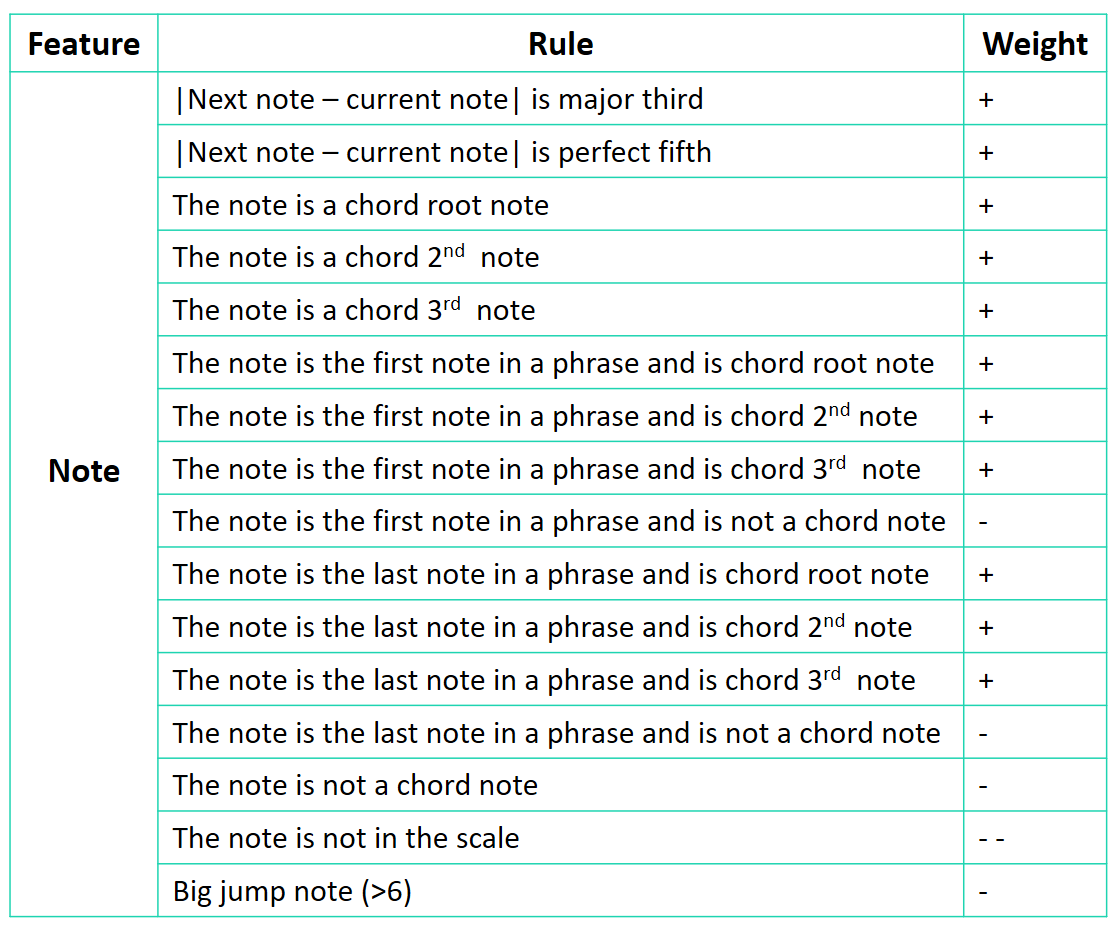

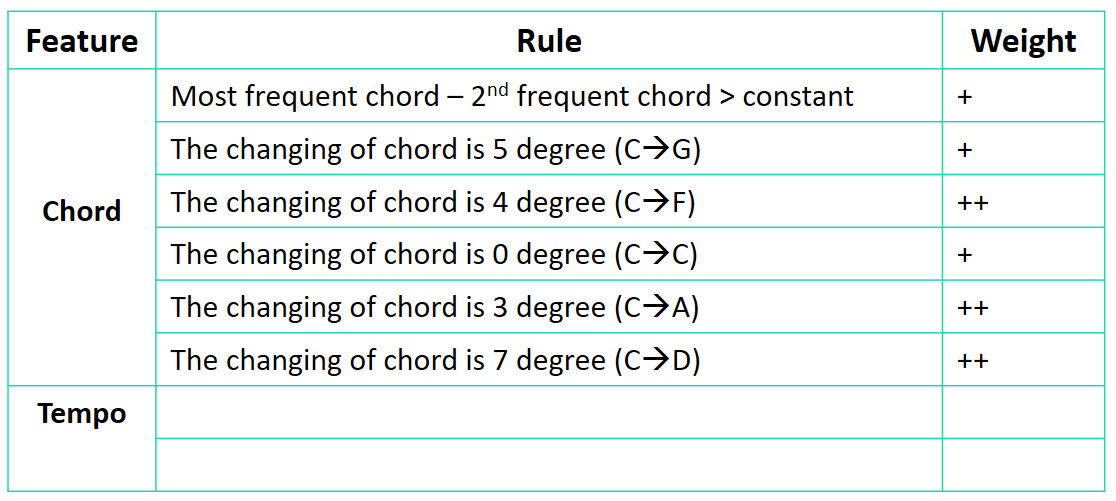

### Output to midi file

In [363]:
def to_midi_file(inputfile, program, outputfile):
    ## initialize
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)
    ## add message
    track.append(Message('program_change', program=program, time=0))
    for i in range(len(inputfile)):
        track.append(Message('note_on', note=inputfile[i].note, velocity=inputfile[i].velocity, time=inputfile[i].time))
    mid.save(outputfile)
    return True

In [367]:
to_midi_file(pop_list[0], 18, 't.mid')

True

---

In [27]:
# random.randint(0,1)
np.random.randn(1)

array([-0.47107465])

In [36]:
round(random.uniform(0, 1),1)

0.9